In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

In [3]:
def tidy_prediction_matrix(prediction_matrix):
    df = pd.melt(prediction_matrix.reset_index(), id_vars='index')
    df.columns = ['mut','query_pos','pred']
    df['mut'] = df.mut.str.upper()
    df['query_pos'] = df.query_pos.str.slice(start=1).astype(int)
    df = df.set_index(['mut','query_pos'])
    return df.pred


def tidy_gemme_predictions(output_dir, query_name, query_seq_file, offset):
    norm_pred_combi = pd.read_csv(f'{output_dir}/{query_name}_normPred_evolCombi.txt',sep='\s+')
    norm_pred_epi = pd.read_csv(f'{output_dir}/{query_name}_normPred_evolEpi.txt',sep='\s+')
    norm_pred_ind = pd.read_csv(f'{output_dir}/{query_name}_normPred_evolInd.txt',sep='\s+')
    pred_epi = pd.read_csv(f'{output_dir}/{query_name}_pred_evolEpi.txt',sep='\s+')
    pred_ind = pd.read_csv(f'{output_dir}/{query_name}_pred_evolInd.txt',sep='\s+')
    pssm = pd.read_csv(f'{output_dir}/{query_name}_pssm.txt',sep='\s+')
    pssm80 = pd.read_csv(f'{output_dir}/{query_name}_pssm80.txt',sep='\s+')
    pssm60 = pd.read_csv(f'{output_dir}/{query_name}_pssm60.txt',sep='\s+')

    gemme_predictions_tidy = pd.DataFrame(dict(
        combi=tidy_prediction_matrix(norm_pred_combi), 
        norm_epi=tidy_prediction_matrix(norm_pred_epi),
        norm_ind=tidy_prediction_matrix(norm_pred_ind),
        epi=tidy_prediction_matrix(pred_epi),
        ind=tidy_prediction_matrix(pred_ind),
        pssm=tidy_prediction_matrix(pssm),
        pssm80=tidy_prediction_matrix(pssm80),
        pssm60=tidy_prediction_matrix(pssm60),
        ))
    gemme_predictions_tidy = gemme_predictions_tidy.reset_index()

    # add conservation
    conservation = pd.read_csv(f'{output_dir}/{query_name}_conservation.txt',sep='\s+')
    conservation = conservation.T
    conservation.index = conservation.index.astype(int)
    gemme_predictions_tidy.merge(conservation, left_on='query_pos',right_index=True)

    # add query residues
    query_sr = SeqIO.read(query_seq_file,format='fasta')
    query_seq = list(query_sr.seq)
    assert len(query_seq) == gemme_predictions_tidy.query_pos.max()
    gemme_predictions_tidy['wt'] = gemme_predictions_tidy.query_pos.map(lambda x: query_seq[x-1])

    # Offset before naming mutants
    gemme_predictions_tidy['pos'] = gemme_predictions_tidy.query_pos + offset
    gemme_predictions_tidy['mutant'] = gemme_predictions_tidy.wt + gemme_predictions_tidy.pos.astype(str) + gemme_predictions_tidy.mut
    return gemme_predictions_tidy

In [13]:
blat_predictions_gemme

,mut,query_pos,combi,norm_epi,norm_ind,epi,ind,pssm,pssm80,pssm60,wt,pos,mutant
0,A,1,0.0,0.0,0.0,1.0,0.000000,-1.913902,-1.506393,-1.737758,H,1,H1A
1,C,1,0.0,0.0,0.0,1.0,0.000000,-1.951694,-1.718505,-1.852628,H,1,H1C
2,D,1,0.0,0.0,0.0,1.0,0.000000,-1.892666,-1.392573,-1.674525,H,1,H1D
3,E,1,0.0,0.0,0.0,1.0,0.000000,-1.853382,-1.191137,-1.559912,H,1,H1E
4,F,1,0.0,0.0,0.0,1.0,0.000000,-1.902359,-1.444073,-1.703273,H,1,H1F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,S,263,0.0,0.0,0.0,1.0,-6.725034,-1.938908,-1.645302,-1.813422,W,263,W263S
5256,T,263,0.0,0.0,0.0,1.0,-6.725034,-1.931289,-1.602390,-1.790225,W,263,W263T
5257,V,263,0.0,0.0,0.0,1.0,-6.725034,-1.936096,-1.629401,-1.804845,W,263,W263V
5258,W,263,NaN,NaN,NaN,0.0,0.000000,10.449780,10.008531,10.274784,W,263,W263W


In [14]:
dms_data

,mutant,km,vmax
0,H24C,0.785765,1.519964
1,H24E,0.757583,1.502589
2,H24D,0.763290,1.622028
3,H24G,1.099628,1.736941
4,H24F,1.074944,1.574923
...,...,...,...
4991,W286S,0.891281,0.140269
4992,W286R,1.498384,0.760712
4993,W286T,3.111094,1.695994
4994,W286V,1.762023,0.824707


In [15]:
dms_data.merge(blat_predictions_gemme)

,mutant,km,vmax,mut,query_pos,combi,norm_epi,norm_ind,epi,ind,pssm,pssm80,pssm60,wt,pos
0,K30A,1.215441,2.643619,A,30,-1.613587,-0.252608,-0.103147,0.280815,-0.135791,-1.023444,-2.534123,0.701370,K,30
1,K30C,0.854707,1.348014,C,30,-3.805195,-0.633052,-4.320684,0.703741,-5.688105,1.933571,-3.303597,-5.251735,K,30
2,K30E,1.226918,1.389399,E,30,-2.199453,-0.374007,-0.088076,0.415769,-0.115951,-0.213746,-2.148511,1.527847,K,30
3,K30D,1.776105,1.281450,D,30,-2.470856,-0.421120,-0.549139,0.468143,-0.722932,-0.183832,-2.835830,-4.385679,K,30
4,K30G,1.626647,1.365892,G,30,-2.481986,-0.282625,-1.359308,0.314184,-1.789505,-1.035324,2.718676,0.758429,K,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,A222R,1.303741,2.449110,R,222,-7.940664,-0.849500,-7.604688,1.000000,-8.951958,1.038232,-4.798484,-3.756057,A,222
186,A222T,1.233386,2.446337,T,222,-2.930146,-0.508648,-6.082589,0.505605,-7.160199,1.094435,4.713321,3.802366,A,222
187,A222W,0.923678,1.359757,W,222,-6.977938,-0.849500,-7.604688,1.000000,-8.951958,-6.781593,-5.706073,-3.930125,A,222
188,A222V,1.255597,2.862600,V,222,-2.886486,-0.279427,-3.581288,0.277756,-4.215760,0.149882,-4.045425,2.849754,A,222


combi       0.618557
norm_epi    0.596433
norm_ind    0.577400
epi        -0.538037
ind         0.558574
Name: vmax, dtype: float64


/tmp/ipykernel_2312/1517116532.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(corr.index.map(nice_labels), rotation=45)


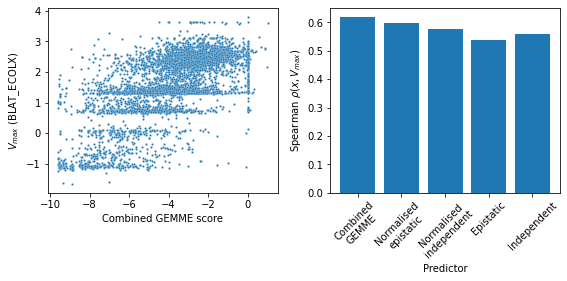

In [20]:
gemme_output_dir = 'tests/BLAT_model/model'
query_name = 'BLAT'
query_seq_file = 'tests/BLAT_model/BLAT_query.fasta'
offset = 23
gemme_predictions_tidy = pd.read_csv('../tests/BLAT_model/model/BLAT_predictions.csv',index_col=0)
gemme_predictions_tidy['pos'] = gemme_predictions_tidy.query_pos + offset
gemme_predictions_tidy['mutant'] = gemme_predictions_tidy.wt + gemme_predictions_tidy.pos.astype(str) + gemme_predictions_tidy.mut

dms_data = pd.read_csv('./blat_ecolx/BLAT_ECOLX_Ranganathan2015.csv',index_col=0)
dms_data = dms_data[['mutant','km','vmax']]
dms_data_w_gemme = dms_data.merge(gemme_predictions_tidy)

fig, ax = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(
    data = dms_data_w_gemme, 
    x = 'combi', y = 'vmax',
    ax = ax[0], s=5
)
ax[0].set_xlabel('Combined GEMME score')
ax[0].set_ylabel(r'$V_{max}$ (BLAT_ECOLX)')

corr = dms_data_w_gemme[['vmax','combi','norm_epi','norm_ind','epi','ind']].corr(method='spearman')['vmax'].iloc[1:]
print(corr)
ax[1].bar(x = corr.index, height= np.abs(corr.values))
nice_labels = {
    'combi':'Combined\nGEMME',
    'norm_epi':'Normalised\nepistatic',
    'norm_ind':'Normalised\nindependent',
    'epi':'Epistatic',
    'ind':'Independent'
}

ax[1].set_xticklabels(corr.index.map(nice_labels), rotation=45)
ax[1].set_xlabel('Predictor')
ax[1].set_ylabel(r'Spearman $\rho (x, V_{max})$')
plt.tight_layout()

In [129]:
gemme_output_dir = 'data/adrb2'
query_name = 'adrb2'
query_seq_file = 'data/adrb2/adrb2.fasta'
offset = 0
adrb2_predictions_gemme = tidy_gemme_predictions(gemme_output_dir, query_name, query_seq_file, offset)
adrb2_predictions_gemme

,mut,query_pos,combi,norm_epi,norm_ind,epi,ind,pssm,pssm80,pssm60,wt,pos,mutant
0,A,1,-1.292701,-0.1666,-1.028553,1.0,-6.173786,-3.683891,-2.735701,-1.536446,M,1,M1A
1,C,1,-1.292701,-0.1666,-1.028553,1.0,-6.173786,-3.704896,-2.954950,-1.567833,M,1,M1C
2,D,1,-1.292701,-0.1666,-1.028553,1.0,-6.173786,-3.856028,-4.558244,-1.743486,M,1,M1D
3,E,1,-1.292701,-0.1666,-1.028553,1.0,-6.173786,-3.809993,-3.624828,-1.651865,M,1,M1E
4,F,1,-1.292701,-0.1666,-1.028553,1.0,-6.173786,-3.595191,-1.671389,-1.352142,M,1,M1F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255,S,413,-1.180522,-0.1585,-0.863990,1.0,-5.451038,-3.016617,-1.393459,-1.711588,L,413,L413S
8256,T,413,-1.180522,-0.1585,-0.863990,1.0,-5.451038,-2.961509,-1.106051,-1.564300,L,413,L413T
8257,V,413,-0.833847,-0.1585,-0.863990,1.0,-5.451038,-2.809204,-0.424341,-1.186509,L,413,L413V
8258,W,413,-1.180522,-0.1585,-0.863990,1.0,-5.451038,-3.003935,-1.251833,-1.639903,L,413,L413W


In [6]:
adrb2_dms_data = pd.read_csv('adrb2/jones_supp2_adrb2_dms_processed.csv')
# Check no offset
find_missing = lambda x: [aa for aa in adrb2_predictions_gemme.mut.unique() if aa not in list(x)]
print(adrb2_dms_data[adrb2_dms_data.Condition==0.625].groupby('Pos').AA.aggregate(find_missing).explode().reset_index().head(10))
print(adrb2_predictions_gemme[['pos','wt']].drop_duplicates().head(10))
# Annotate with WT residues
sr = SeqIO.read(query_seq_file,format='fasta')
wt_seq = list(sr.seq)
adrb2_dms_data['wt'] = adrb2_dms_data.Pos.map(lambda x: wt_seq[x-1])
adrb2_dms_data['mutant'] = adrb2_dms_data.wt + adrb2_dms_data.Pos.astype(str) + adrb2_dms_data.AA

# Simple filter for now
print(adrb2_dms_data.columns)
print(adrb2_dms_data.Condition.unique())
target_col = 'Norm'
select_condition = 0.625
adrb2_dms_data = adrb2_dms_data[adrb2_dms_data.Condition==select_condition]
adrb2_dms_data = adrb2_dms_data[['mutant',target_col]]
dms_data_w_gemme = adrb2_predictions_gemme.merge(adrb2_dms_data)

fig, ax = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(
    data = dms_data_w_gemme, 
    x = 'combi', y = target_col,
    ax = ax[0], s=5, alpha=0.1
)
ax[0].set_yscale('log')
ax[0].set_ylim((0.5, 5))
ax[0].set_xlabel('Combined GEMME score')
ax[0].set_ylabel(r'DMS score (ADRB2_HUMAN)')
corr = dms_data_w_gemme[[target_col,'combi','norm_epi','norm_ind','epi','ind']].corr(method='spearman')[target_col].iloc[1:]
ax[1].bar(x = corr.index, height= np.abs(corr.values))
nice_labels = {
    'combi':'Combined\nGEMME',
    'norm_epi':'Normalised\nepistatic',
    'norm_ind':'Normalised\nindependent',
    'epi':'Epistatic',
    'ind':'Independent'
}
labels = corr.index.map(nice_labels)
ax[1].set_xticklabels(labels, rotation=45)
ax[1].set_xlabel('Predictor')
ax[1].set_ylabel(r'Spearman $\rho$ (x, DMS score)')
print(dict(zip(labels, corr.values)))
plt.tight_layout()

NameError: name 'adrb2_predictions_gemme' is not defined

Condition,0.000,0.150,0.625,5.000
Condition,,,,
0.000,1.000000,0.709001,0.691993,0.334352
0.150,0.709001,1.000000,0.755021,0.410364
0.625,0.691993,0.755021,1.000000,0.465587
5.000,0.334352,0.410364,0.465587,1.000000


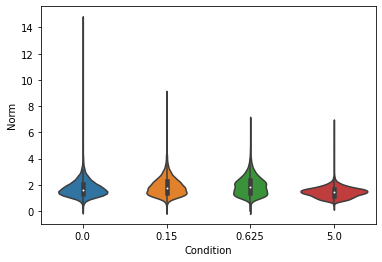

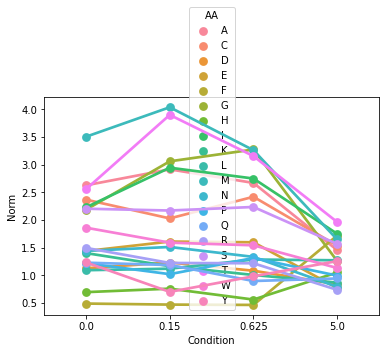

In [225]:
adrb2_dms_data = pd.read_csv('data/adrb2/jones_supp2_adrb2_dms_processed.csv')

sns.violinplot(
    data = adrb2_dms_data, x = 'Condition', y = 'Norm'
)
plt.subplots()

sns.pointplot(data=adrb2_dms_data[adrb2_dms_data.Pos==52], x = 'Condition', y = 'Norm', hue='AA')

adrb2_dms_data.pivot(index = ['Pos','AA'], columns = 'Condition', values='Norm').corr()

/tmp/ipykernel_3567/2276478899.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(corr.index.map(nice_labels), rotation=45)


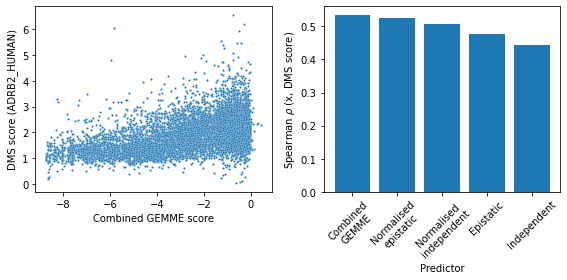

In [236]:
adrb2_dms_data = pd.read_csv('data/adrb2/jones_supp2_adrb2_dms_processed.csv')
# Annotate with WT residues
sr = SeqIO.read(query_seq_file,format='fasta')
wt_seq = list(sr.seq)
adrb2_dms_data['wt'] = adrb2_dms_data.Pos.map(lambda x: wt_seq[x-1])
adrb2_dms_data['mutant'] = adrb2_dms_data.wt + adrb2_dms_data.Pos.astype(str) + adrb2_dms_data.AA

# Exclude outliers and take mean
target_col = 'Norm'
adrb2_dms_data = adrb2_dms_data[adrb2_dms_data.Condition.isin((0.15, 0.625))].groupby('mutant').Norm.mean().reset_index()
adrb2_dms_data = adrb2_dms_data[['mutant',target_col]]
dms_data_w_gemme = adrb2_predictions_gemme.merge(adrb2_dms_data)

fig, ax = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(
    data = dms_data_w_gemme, 
    x = 'combi', y = target_col,
    ax = ax[0], s=5
)
ax[0].set_xlabel('Combined GEMME score')
ax[0].set_ylabel(r'DMS score (ADRB2_HUMAN)')
corr = dms_data_w_gemme[[target_col,'combi','norm_epi','norm_ind','epi','ind']].corr(method='spearman')[target_col].iloc[1:]
ax[1].bar(x = corr.index, height= np.abs(corr.values))
nice_labels = {
    'combi':'Combined\nGEMME',
    'norm_epi':'Normalised\nepistatic',
    'norm_ind':'Normalised\nindependent',
    'epi':'Epistatic',
    'ind':'Independent'
}

ax[1].set_xticklabels(corr.index.map(nice_labels), rotation=45)
ax[1].set_xlabel('Predictor')
ax[1].set_ylabel(r'Spearman $\rho$ (x, DMS score)')
plt.tight_layout()

# Not useful 

<AxesSubplot:xlabel='Condition', ylabel='norm_zscore_robust'>

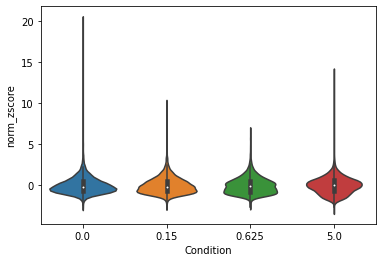

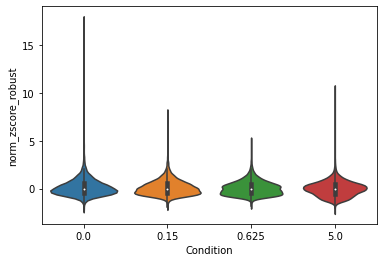

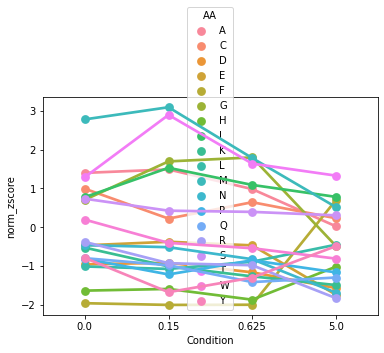

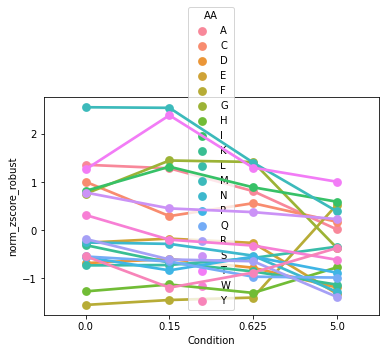

In [223]:
# Transform to Z scores 
iqr = lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25)
stats_by_condition = adrb2_dms_data.groupby('Condition').Norm.aggregate(norm_median = np.median, norm_iqr=iqr, norm_mean = np.mean, norm_std = np.std).reset_index()
adrb2_dms_data_zscores = adrb2_dms_data.merge(stats_by_condition)
adrb2_dms_data_zscores['norm_zscore'] = (adrb2_dms_data_zscores.Norm - adrb2_dms_data_zscores.norm_mean) / adrb2_dms_data_zscores.norm_std
adrb2_dms_data_zscores['norm_zscore_robust'] = (adrb2_dms_data_zscores.Norm - adrb2_dms_data_zscores.norm_median) / adrb2_dms_data_zscores.norm_iqr
sns.violinplot(
    data = adrb2_dms_data_zscores, x = 'Condition', y = 'norm_zscore'
)

plt.subplots()
sns.violinplot(
    data = adrb2_dms_data_zscores, x = 'Condition', y = 'norm_zscore_robust'
)

plt.subplots()
sns.pointplot(data=adrb2_dms_data_zscores[adrb2_dms_data_zscores.Pos==52], x = 'Condition', y = 'norm_zscore', hue='AA')

plt.subplots()
sns.pointplot(data=adrb2_dms_data_zscores[adrb2_dms_data_zscores.Pos==52], x = 'Condition', y = 'norm_zscore_robust', hue='AA')